<a href="https://colab.research.google.com/github/VarunaAggarwal/VarunaAggarwal/blob/main/Flood_Modelling_DRDO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install necessary libraries**

In [33]:
!pip install rasterio geopandas folium matplotlib

# **Import libraries**

In [35]:
import rasterio
import geopandas as gpd
import numpy as np
import folium
from rasterio.plot import show
import matplotlib.pyplot as plt

# **Load DEM file (Upload your DEM file in Colab, or use a sample one)**

In [40]:
from google.colab import files
uploaded = files.upload()  # Upload a .tif DEM file here

import os
dem_path = next(iter(uploaded.keys()))  # Automatically get uploaded file name

Saving N26E091.hgt to N26E091.hgt


# **Read DEM data**
This code uses the Rasterio library to open and read a Digital Elevation Model (DEM) GeoTIFF file. Here's what each part does:

In [41]:
with rasterio.open(dem_path) as src:
    dem = src.read(1)
    transform = src.transform
    crs = src.crs

# **Define synthetic breach: lower elevation in a region**
* Assume breach center near middle of DEM. This sets the location of the breach at the center of the DEM.

dem.shape[0] → number of rows (height of the DEM)

dem.shape[1] → number of columns (width of the DEM)

* breach_radius = 20

This defines how big the breach area is — a square region with a radius of 20 pixels from the center.

It means the breach will cover a 40×40 grid (from -20 to +20).

In [42]:
breach_row, breach_col = dem.shape[0] // 2, dem.shape[1] // 2
breach_radius = 20
breach_depth = 10  # meters of sudden drop

for i in range(-breach_radius, breach_radius):
    for j in range(-breach_radius, breach_radius):
        if 0 <= breach_row+i < dem.shape[0] and 0 <= breach_col+j < dem.shape[1]:
            dem[breach_row+i, breach_col+j] -= breach_depth

# **Simulate flood extent: simple threshold model**
* Any terrain that's in the lowest 30% elevation is assumed to be at risk of flooding.

* This makes sense in a dam-break scenario, because:

1. Water flows to lower-lying areas

2. The flood is likely to spread across the lowest parts of the terrain

In [43]:
flood_threshold = np.percentile(dem[dem > 0], 30)  # Flood areas below 30th percentile
flood_extent = dem < flood_threshold

# **Plot result**
 This block of code uses Matplotlib to visually display your simulated flood extent on a 2D plot.

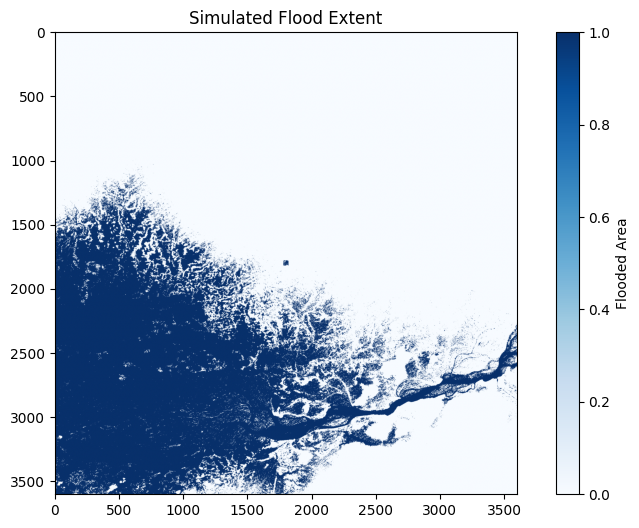

In [44]:
plt.figure(figsize=(10,6))
plt.imshow(flood_extent, cmap='Blues')
plt.title("Simulated Flood Extent")
plt.colorbar(label='Flooded Area')
plt.show()

# **Convert flood extent to coordinates for Folium map**
* rasterio.transform.xy()
Converts a pixel location (row, col) into real-world coordinates using the transform matrix.
* return y, x
Switches order to return as (latitude, longitude), which is what mapping libraries like Folium expect.

In [45]:
def pixel_to_coords(row, col, transform):
    x, y = rasterio.transform.xy(transform, row, col)
    return y, x  # Return as (lat, lon)

flood_coords = []
for row in range(0, dem.shape[0], 10):
    for col in range(0, dem.shape[1], 10):
        if flood_extent[row, col]:
            flood_coords.append(pixel_to_coords(row, col, transform))

# **Display on Folium map**
1. if flood_coords:
* Checks whether the list flood_coords contains any flooded points.

* If it's empty, that means no flood was detected — so the code skips the map part and prints a message.

2. lat_center, lon_center = flood_coords[0]
* Gets the first flooded point to use as the center of the map.

* flood_coords is a list of (lat, lon) tuples, so this just picks the first one.

3. flood_map = folium.Map(...)
* Creates a Folium map centered at the first flooded location.

* zoom_start=12 sets the initial zoom level. You can change this (e.g., 13 for more zoomed-in).

4. for lat, lon in flood_coords[::100]:
* Loops through the list of flood points but only takes every 100th point:

* ::100 is Python slice notation.

* This makes the map load faster and not overcrowded with points.

In [46]:
if flood_coords:
    lat_center, lon_center = flood_coords[0]
    flood_map = folium.Map(location=[lat_center, lon_center], zoom_start=12)

    for lat, lon in flood_coords[::100]:  # Show every 100th point
        folium.CircleMarker(location=[lat, lon], radius=2, color='blue', fill=True).add_to(flood_map)

    flood_map
else:
    print("No flood area detected.")

# **Define breach location manually**


In [47]:
breach_row, breach_col = dem.shape[0] // 2, dem.shape[1] // 2
breach_depth = 10
breach_radius = 10

# **Simulate flood growth over time (e.g., hourly spread)**
1. time_steps = 5
* You're simulating the flood spread over 5 time intervals (e.g., 5 hours).
* Each loop represents one hour after the breach.
2. flood_layers = []
* This is a list that will store one flood map per time step.
* After the loop, flood_layers[0] is the first hour, flood_layers[1] the second, and so on.
3. Main Loop
* Loops from 1 to 5 (inclusive), representing 5 time points.
4. spread = breach_radius * t
* Models the idea that the flood spreads outward over time.
* Every hour, the flood can reach farther from the breach.
5. temp_dem = dem.copy()
* You make a copy of the DEM to simulate each flood step without altering the original terrain.
6. Simulated Breach Depth (Gradient)
* This lowers the elevation in a circular region, with depth decreasing from the center outward.
* Simulates a radial gradient — deepest at the center, shallower at the edges.
7. Flooding Decision by Elevation
* Floods the lowest 30% of elevation values (same method you used earlier).

In [48]:
time_steps = 5  # 5 time intervals (e.g., hours)
flood_layers = []

for t in range(1, time_steps + 1):
    spread = breach_radius * t  # Flood spread grows each step
    temp_dem = dem.copy()

    for i in range(-spread, spread):
        for j in range(-spread, spread):
            row = breach_row + i
            col = breach_col + j
            if 0 <= row < dem.shape[0] and 0 <= col < dem.shape[1]:
                dist = np.sqrt(i**2 + j**2)
                if dist <= spread:
                    temp_dem[row, col] -= breach_depth * (1 - dist / spread)

    # Threshold method to simulate flooding
    flood_threshold = np.percentile(temp_dem[temp_dem > 0], 30)
    flood_extent = temp_dem < flood_threshold
    flood_layers.append(flood_extent)


# **Utility: Convert pixel to lat/lon**


1.   Lat/Lon, short for Latitude and Longitude, is the most common way to represent a location on Earth's surface using geographic coordinates.
2.   The DEM has a transform matrix that lets you convert grid rows/columns into real-world lat/lon coordinates.
3.   This is crucial for:
*   Mapping flood data on Folium/Leaflet
*   Calculating distances (e.g., breach to village)
*   Exporting shapefiles/GeoTIFFs with correct geolocation



In [49]:
def pixel_to_coords(row, col, transform):
    x, y = rasterio.transform.xy(transform, row, col)
    return y, x  # Folium wants (lat, lon)

# **Create River Path (center vertical line for simplicity)**
* Generates a list of pixel coordinates (row, column) that simulate a vertical river going through the breach point.
* Converts each (row, col) pixel coordinate of the river into real-world geographic coordinates using the earlier pixel_to_coords() function.
* river_latlon is a list of (latitude, longitude) tuples — perfect for plotting with Folium or Leaflet.


In [50]:
river_coords = [(r, breach_col) for r in range(max(0, breach_row - 50), min(dem.shape[0], breach_row + 50))]
river_latlon = [pixel_to_coords(r, c, transform) for r, c in river_coords]

# **Draw river path**
This code creates an interactive map using **Folium**, centered at the **breach location** obtained by converting DEM pixel coordinates to geographic latitude and longitude. It then plots a **synthetic river path** as a blue line that passes vertically through the breach point. The map allows zooming, panning, and interaction, helping visualize where the breach occurs and how the river is positioned in relation to the terrain.


In [51]:
# Get breach point lat/lon
breach_latlon = pixel_to_coords(breach_row, breach_col, transform)

# Visualize on Folium
import folium

# Center map at breach
flood_map = folium.Map(location=breach_latlon, zoom_start=13)

# Draw river path
folium.PolyLine(river_latlon, color='blue', weight=3, tooltip='Synthetic River').add_to(flood_map)

# **Add breach marker**
This code adds a red marker to the Folium map at the breach location. It helps visually identify where the dam breach occurred.
* location=breach_latlon: Places the marker at the breach's latitude and longitude.
* tooltip='Breach Location': Shows a label when you hover over the marker.
* icon=folium.Icon(...): Customizes the marker icon:
* color='red': Makes the marker red (indicating danger).
* icon='exclamation-sign': Adds a warning-style icon.

In [52]:
folium.Marker(
    location=breach_latlon,
    tooltip='Breach Location',
    icon=folium.Icon(color='red', icon='exclamation-sign')
).add_to(flood_map)

# **Add flood extent (from final time step only)**
This code block visualizes the final flood extent on the interactive Folium map by adding small cyan dots to represent flooded areas.
This code displays the final flood extent on a Folium map by plotting cyan circle markers at flooded locations, helping you visualize which areas are inundated after the dam breach simulation.
* Plots every 50th point to avoid map overload.
* Each flooded point is shown as a small cyan circle.
* Adds them to the existing flood_map.

In [53]:
final_flood = flood_layers[-1]
flood_coords = [pixel_to_coords(row, col, transform)
                for row in range(0, dem.shape[0], 5)
                for col in range(0, dem.shape[1], 5)
                if final_flood[row, col]]

for lat, lon in flood_coords[::50]:  # reduce points for performance
    folium.CircleMarker(location=[lat, lon], radius=1.5, color='cyan', fill=True).add_to(flood_map)

flood_map

# **Area of Flooded Region (in km²)**

In [54]:
# Calculate flooded area in square kilometers
pixel_size_x = abs(transform[0])  # cell width in degrees
pixel_size_y = abs(transform[4])  # cell height in degrees

# Approximate meter per degree (rough for small areas)
meter_per_degree = 111_000

cell_area_km2 = (pixel_size_x * meter_per_degree) * (pixel_size_y * meter_per_degree) / 1e6
flooded_cells = np.sum(final_flood)
flooded_area_km2 = flooded_cells * cell_area_km2

print(f"Estimated Flooded Area: {flooded_area_km2:.2f} km²")


Estimated Flooded Area: 3547.90 km²


# **Animated Flood Spread (Matplotlib animation)**
Shows how flood evolves over time.

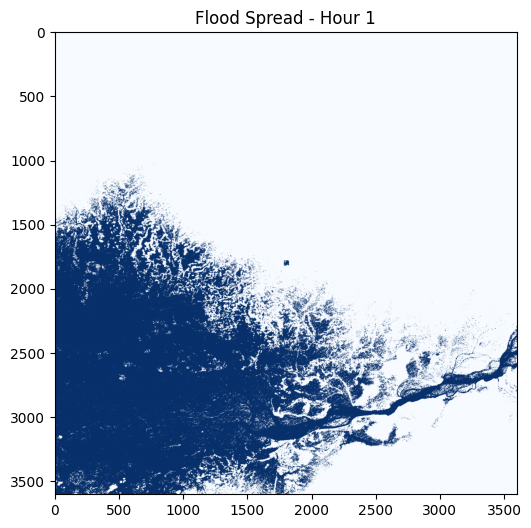

In [55]:
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(8, 6))
img = ax.imshow(flood_layers[0], cmap='Blues', animated=True)
ax.set_title("Flood Progression Over Time")

def update(i):
    img.set_array(flood_layers[i])
    ax.set_title(f"Flood Spread - Hour {i+1}")
    return img,

ani = animation.FuncAnimation(fig, update, frames=len(flood_layers), interval=800, blit=True)
plt.show()


# **Downloadable Flood Map (as Image or GeoTIFF)**

In [56]:
plt.imsave("final_flood_map.png", final_flood, cmap='Blues')
from google.colab import files
files.download("final_flood_map.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Calculate Distance from Breach to Flooded Points**

In [57]:
from geopy.distance import geodesic

max_distance_km = 0
for lat, lon in flood_coords:
    dist = geodesic(breach_latlon, (lat, lon)).km
    max_distance_km = max(max_distance_km, dist)

print(f"Max Distance Flood Spread from Breach: {max_distance_km:.2f} km")


Max Distance Flood Spread from Breach: 74.59 km
